# keras with image MNIST

## pylibs

In [2]:
import os
import cv2
import random
import numpy as np
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.models import load_model
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.callbacks import Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


## data processing with image

In [3]:
SIF = 1
DDA = 1
#data_augmentation
def data_augmentation(image):
    new_image = np.zeros_like(image)
    # Resize image to a random size between 24 and 28
    new_size = np.random.randint(24, 28)
    image = zoom(image, (new_size / image.shape[0], new_size / image.shape[1], 1))
    pad_size = (np.random.randint(1, 18), np.random.randint(1, 18))
    # Choose a random side or corner to pad from
    side_or_corner = np.random.choice(['top', 'bottom', 'left', 'right', 'top-left', 'top-right', 'bottom-left', 'bottom-right', 'AD'])

    # Set the padding size based on the chosen side or corner
    if side_or_corner == 'top':
        pad_size = ((pad_size[0], 0), (0, 0), (0, 0))
    elif side_or_corner == 'bottom':
        pad_size = ((0, pad_size[0]), (0, 0), (0, 0))
    elif side_or_corner == 'left':
        pad_size = ((0, 0), (pad_size[1], 0), (0, 0))
    elif side_or_corner == 'right':
        pad_size = ((0, 0), (0, pad_size[1]), (0, 0))
    elif side_or_corner == 'top-left':
        pad_size = ((pad_size[0], 0), (pad_size[1], 0), (0, 0))
    elif side_or_corner == 'top-right':
        pad_size = ((pad_size[0], 0), (0, pad_size[1]), (0, 0))
    elif side_or_corner == 'bottom-left':
        pad_size = ((0, pad_size[0]), (pad_size[1], 0), (0, 0))
    elif side_or_corner == 'bottom-right':
        pad_size = ((0, pad_size[0]), (0, pad_size[1]), (0, 0))
    else: #'AD'
        pad_size = ((pad_size[1], pad_size[1]), (pad_size[1], pad_size[1]), (0, 0))
        
    padded_image = np.pad(image, pad_size, mode='constant')

    new_image = padded_image
    image = new_image
    
    resized_image = cv2.resize(image, (28, 28))
    image = resized_image[:, :, np.newaxis]
    new_image = image
    
    crop_size = np.random.randint(23, 28)
    # Choose a random direction
    direction = np.random.choice(['up', 'down', 'left', 'right'])

    # Set the starting position of the cropped image based on the chosen direction
    if direction == 'up':
        start_x = np.random.randint(0, image.shape[1] - crop_size)
        start_y = 0
    elif direction == 'down':
        start_x = np.random.randint(0, image.shape[1] - crop_size)
        start_y = image.shape[0] - crop_size
    elif direction == 'left':
        start_x = 0
        start_y = np.random.randint(0, image.shape[0] - crop_size)
    else:  # 'right'
        start_x = image.shape[1] - crop_size
        start_y = np.random.randint(0, image.shape[0] - crop_size)

    # Crop the image
    cropped_image = image[start_y:start_y+crop_size, start_x:start_x+crop_size]

    image = cropped_image
    new_image = image
    resized_image = cv2.resize(image, (28, 28))
    image = resized_image[:, :, np.newaxis]
    new_image = image
    
    noise_func = np.random.choice(['L1', 'L2', 'L3', 'none'])
    intensityL2 = random.uniform(0.5, 1.4)
    intensityL1 = random.uniform(0.5, 1.4)
    if noise_func == 'L2' or noise_func == 'L3':
        for i in range(0, image.shape[0], 4):
            for j in range(0, image.shape[1], 4):
                block = image[i:i+4, j:j+4]
                block = (np.random.rand() * intensityL2 + 1) * block
                new_image[i:i+4, j:j+4] = block
        image = new_image      
    elif noise_func == 'L1' or noise_func == 'L3': 
        for i in range(0, image.shape[0], 2):
            for j in range(0, image.shape[1], 2):
                block = image[i:i+2, j:j+2]
                block = (np.random.rand() * intensityL1 + 1) * block
                new_image[i:i+2, j:j+2] = block
    return new_image
#save_images_to_dir
def save_images_to_dir(images, labels, dir_path):
    # create the directory if it doesn't exist
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    # iterate over the images and labels
    for i, (image, label) in enumerate(zip(images, labels)):
        # get the class label
        class_label = np.argmax(label)
        # create the file path
        file_path = os.path.join(dir_path, f'image_{i}_class_{class_label}.png')
        # save the image to the file path
        plt.imsave(file_path, image.squeeze(), cmap='gray')

# load dataset
with np.load('mnist.npz') as data:
    x_train, y_train = data['x_train'], data['y_train']
    x_test, y_test = data['x_test'], data['y_test']

# reshape dataset to have a single channel
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# one hot encode target values
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# data processing
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# create a data generator
datagen = ImageDataGenerator(rotation_range=90, horizontal_flip=True, preprocessing_function=lambda x: data_augmentation(1-x))

# prepare an iterators to scale images
train_iterator = datagen.flow(x_train, y_train, batch_size=len(x_train))
test_iterator = datagen.flow(x_test, y_test, batch_size=len(x_test))

# get augmented data
x_train_augmented, y_train_augmented = train_iterator.next()
x_test_augmented, y_test_augmented = test_iterator.next()

# append augmented data to original data
x_train = np.concatenate([x_train, x_train_augmented])
y_train = np.concatenate([y_train, y_train_augmented])
x_test = np.concatenate([x_test, x_test_augmented])
y_test = np.concatenate([y_test, y_test_augmented])

if DDA:
    # prepare an iterators to scale images
    train_iterator = datagen.flow(x_train, y_train, batch_size=len(x_train))
    test_iterator = datagen.flow(x_test, y_test, batch_size=len(x_test))

    # get augmented data
    x_train_augmented, y_train_augmented = train_iterator.next()
    x_test_augmented, y_test_augmented = test_iterator.next()

    # append augmented data to original data
    x_train = np.concatenate([x_train, x_train_augmented])
    y_train = np.concatenate([y_train, y_train_augmented])
    x_test = np.concatenate([x_test, x_test_augmented])
    y_test = np.concatenate([y_test, y_test_augmented])
    
    # prepare an iterators to scale images
    train_iterator = datagen.flow(x_train, y_train, batch_size=len(x_train))
    test_iterator = datagen.flow(x_test, y_test, batch_size=len(x_test))

    # get augmented data
    x_train_augmented, y_train_augmented = train_iterator.next()
    x_test_augmented, y_test_augmented = test_iterator.next()

    # append augmented data to original data
    x_train = np.concatenate([x_train, x_train_augmented])
    y_train = np.concatenate([y_train, y_train_augmented])
    x_test = np.concatenate([x_test, x_test_augmented])
    y_test = np.concatenate([y_test, y_test_augmented])

# save augmented data to directories
if SIF:
    #save_images_to_dir(x_train_augmented, y_train_augmented, 'train')
    save_images_to_dir(x_test_augmented, y_test_augmented, 'test')


## Creating the model

In [4]:
print('Creating a model...\n')

model = Sequential()
model.add(Conv2D(256, (6, 6), activation='relu', input_shape=(28, 28, 1), kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(512, (4, 4), activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.6))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.1), kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.1), kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))
# compile model
opt = SGD(learning_rate=0.02, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
print('\nThe model was successfully created')

Creating a model...

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 256)       9472      
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 256)      1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2097664   
                                                                 
 batch_normalization_1 (Batc  (None

## loading the model

In [5]:
try:
    model = load_model('MNIST_model.h5')
except (ImportError, IOError) as e:
    print(f'\033[91mfailed to load the model ERROR:\n{e}')
else:
    print('\033[92m loading model done.')

failed to load the model ERROR:
No file or directory found at MNIST_model.h5


## Training

In [6]:

early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, restore_best_weights = True)

print('Training the model...\n')
history = model.fit(x_train, y_train, epochs=256, batch_size=64, validation_data=(x_test, y_test), verbose='auto', callbacks=[early_stopping])
print('Training done.\n')

Training the model...

Epoch 1/256
7500/7500 [==============================] - 100s 12ms/step - loss: 3.3035 - accuracy: 0.2360 - val_loss: 2.8392 - val_accuracy: 0.2784
Epoch 2/256
7500/7500 [==============================] - 92s 12ms/step - loss: 2.6674 - accuracy: 0.3637 - val_loss: 2.4800 - val_accuracy: 0.4463
Epoch 3/256
7500/7500 [==============================] - 92s 12ms/step - loss: 2.5634 - accuracy: 0.4277 - val_loss: 2.3042 - val_accuracy: 0.5248
Epoch 4/256
7500/7500 [==============================] - 92s 12ms/step - loss: 2.4760 - accuracy: 0.4665 - val_loss: 2.3698 - val_accuracy: 0.5559
Epoch 5/256
7500/7500 [==============================] - 91s 12ms/step - loss: 2.3969 - accuracy: 0.4947 - val_loss: 2.1203 - val_accuracy: 0.5803
Epoch 6/256
7500/7500 [==============================] - 91s 12ms/step - loss: 2.3108 - accuracy: 0.5162 - val_loss: 2.0662 - val_accuracy: 0.5938
Epoch 7/256
7500/7500 [==============================] - 92s 12ms/step - loss: 2.2370 - accura

## Saving model weights

In [7]:
model.save('MNIST_model.h5')

## Analyzing the results

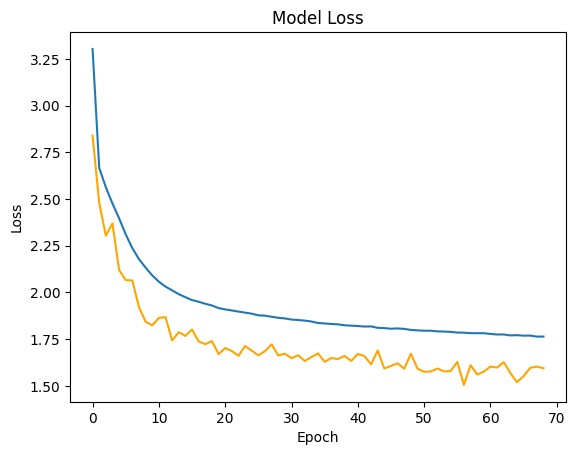

In [8]:
try:
    plt.plot(history.history['loss'], label='loss')
    try:
        plt.plot(history.history['val_loss'], label='val_loss', color='orange')
    except (ValueError, NameError):
        print('\033[91mfailed to load val_loss.')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
except (ValueError, NameError):
    print('\033[91mfailed to load model history.')

In [11]:
from keras.models import load_model
from PIL import Image, ImageFilter
import numpy as np
import os
import matplotlib.pyplot as plt
import sys

try:
    model = load_model('MNIST_model.h5')
except (ImportError, IOError) as e:
    print(f'failed to load the model ERROR:\n{e}')
    sys.exit()
else:
    print('loading model done.')

# Load and preprocess image
image_dir = input('image dir(.png/.jpg):')
if image_dir == '':
    image_dir = 'image.jpg'
try:
    img = Image.open(image_dir).convert('L')
    if img.format == 'JPEG':
        img = img.convert('RGB')
except FileNotFoundError:
    try:
        img = Image.open(image_dir).convert('L')
        if img.format == 'JPEG':
            img = img.convert('RGB')
    except FileNotFoundError:
        print('cant find: image.(png/jpg)')
        sys.exit()
    
img = img.resize((28, 28))
img = img.filter(ImageFilter.GaussianBlur(0.5))
img_array = np.array(img)
img_array = img_array.reshape(1, 28, 28, 1)

# Make predictions
predictions = model.predict(img_array)
predicted_digit = np.argmax(predictions)
confidence = predictions[0][predicted_digit]
print(f'The predicted digit is {predicted_digit} with a confidence of {confidence:.3f}')
print('other digits:')
for i in range(len(predictions[0])):
    print(f'{i} with a confidence of {predictions[0][i]:.3f}')
    



loading model done.
1/1 [==============================] - 0s 117ms/step
The predicted digit is 5 with a confidence of 1.000
other digits:
0 with a confidence of 0.000
1 with a confidence of 0.000
2 with a confidence of 0.000
3 with a confidence of 0.000
4 with a confidence of 0.000
5 with a confidence of 1.000
6 with a confidence of 0.000
7 with a confidence of 0.000
8 with a confidence of 0.000
9 with a confidence of 0.000
